# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [16]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
#import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
#import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

### Reading the Cleaned Dataset

In [2]:
# Read the file
df2 = pd.read_csv('C:/users/eturk/Data_Science/Capstone_Project-Sentiment_Analysis/Dataset/cleaned_dataset.csv')

In [3]:
# Sample observations
df2.head(3)

,customer,product,review_text,rating_class,year,clean_text,tokens
0,A6VPK7X53QNAQ,B0000CC64W,If I had to choose only one product to take ca...,good,2009,choose one product take care face rest life wo...,"['choose', 'one', 'product', 'take', 'care', '..."
1,A3CHMHGSJSQ02J,B0000CC64W,Makes my skin lovely and smooth As a woman nea...,good,2013,make skin lovely smooth woman near need help g...,"['make', 'skin', 'lovely', 'smooth', 'woman', ..."
2,A1V1EP514B5H7Y,B0000CC64W,Works well at a reasonable price I've used thi...,good,2011,work well reasonable price use regenerating se...,"['work', 'well', 'reasonable', 'price', 'use',..."


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers. 

We will implement CounterVectorizer, TF-IDF, Hash Vectorizer, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

**Separating Response Variable and Feature**

In [4]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [5]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data. 

In [6]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(18381,)
Test Set Shape		:(6128,)


## 3. Selecting the Right Evaluation Metric

Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

**Confusion Matrix Plot Function**

Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [9]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling 

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by females who bought beauty products in Amazon e-commerce online platform.  We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.  

Since the ratings of the reviews were not distributed normally, we decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Bad’ and Rating 4-5 as 'Good' while dropping Rating 3 from the dataset. 

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition. 

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors. 

## 4.1 CountVectorizer Bag of Words

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

**"CountVectorizer"** implements both tokenization and occurrence counting in a single class. 

In [10]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [11]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 21808


In [12]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [13]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,___________________________________________________________i,_____________________________________________i,________________________________________product,_____________________addendum,aa,aaa,aaaaahhhhhhh,aaaah,aaaahhhh,aaack,...,zone,zoo,zoolander,zoom,zoomlash,zwill,zwilling,zync,zz,zzzzap
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Creating a function for applying different algorithms**

In [14]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### Dummy Classifier

In [17]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.8456124626726497


**Classification Report**

In [18]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.08      0.08       514
           1       0.92      0.91      0.92      5614

   micro avg       0.85      0.85      0.85      6128
   macro avg       0.50      0.50      0.50      6128
weighted avg       0.85      0.85      0.85      6128



**Confusion Matrix**

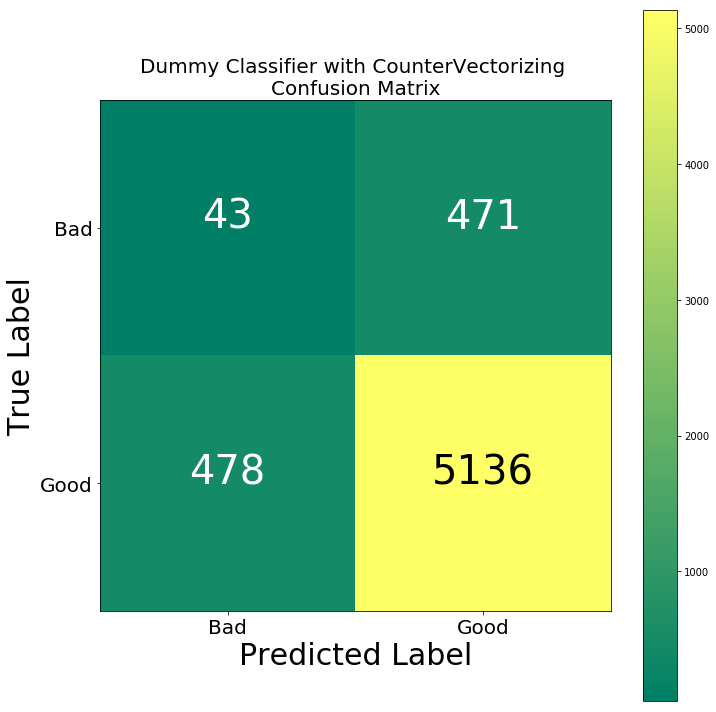

In [19]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred, "Dummy Classifier")

### 4.1.1 Logistic Regression with CountVectorizer

In [17]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9229260093841383


**Classification Report**

In [18]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59       514
           1       0.97      0.93      0.95      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.74      0.83      0.77      6128
weighted avg       0.93      0.92      0.92      6128



**Confusion Matrix**

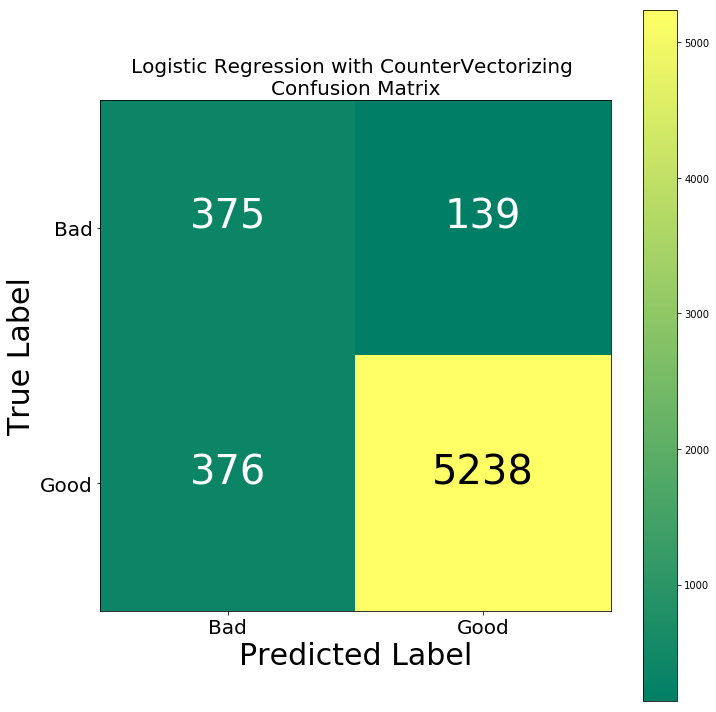

In [19]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer

In [20]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.879188119188214


**Classification Report**

In [21]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

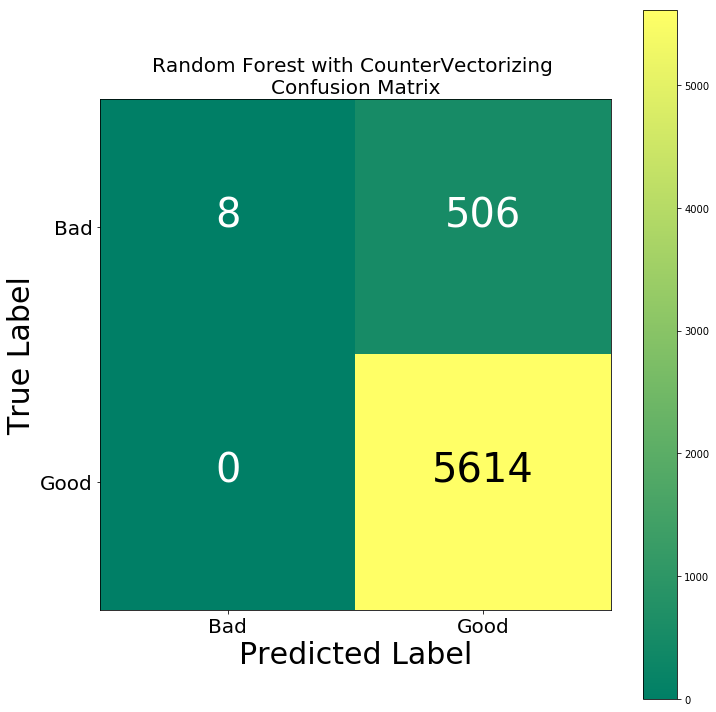

In [22]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer 

In [23]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9244233192137602


**Classification Report**

In [24]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.82      0.68      0.73      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

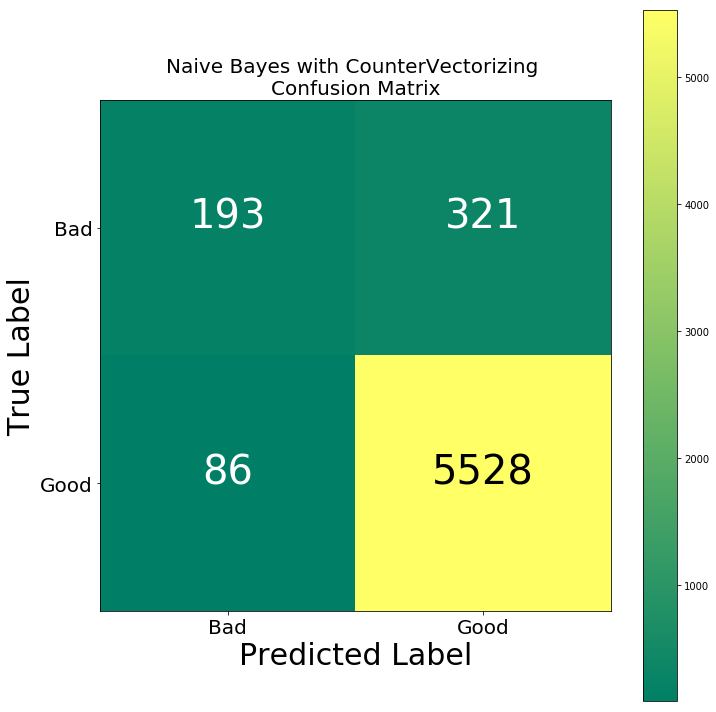

In [25]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

### 4.1.4 XGBoost with CountVectorizer

In [26]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8941529692558983


**Classification Report**

In [27]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.79      0.10      0.18       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.86      0.55      0.57      6128
weighted avg       0.91      0.92      0.89      6128



**Confusion Matrix**

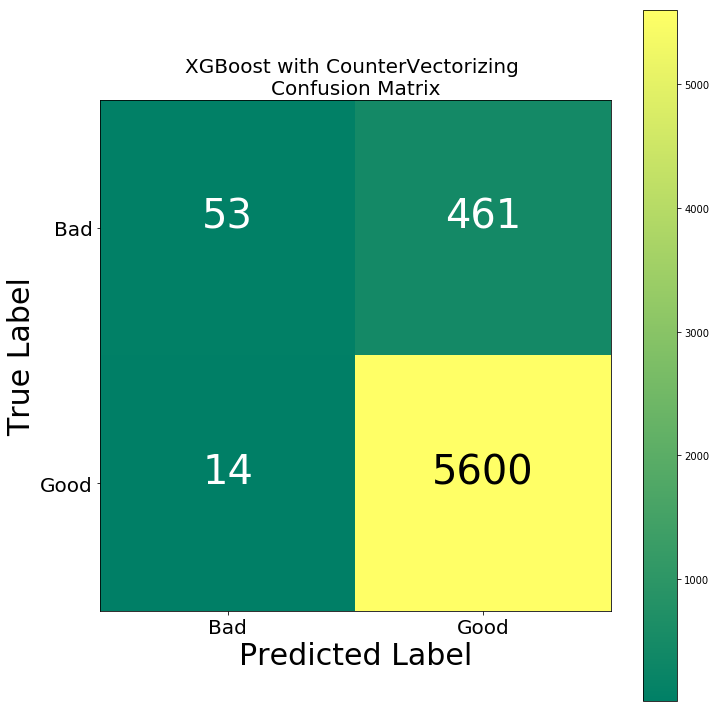

In [28]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.5 CatBoost with CountVectorizer

In [29]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1000, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3018353	total: 116ms	remaining: 1m 56s
1:	learn: 0.2685483	total: 157ms	remaining: 1m 18s
2:	learn: 0.2575143	total: 195ms	remaining: 1m 4s
3:	learn: 0.2542816	total: 234ms	remaining: 58.2s
4:	learn: 0.2482395	total: 274ms	remaining: 54.6s
5:	learn: 0.2396284	total: 311ms	remaining: 51.6s
6:	learn: 0.2366616	total: 357ms	remaining: 50.7s
7:	learn: 0.2308369	total: 405ms	remaining: 50.2s
8:	learn: 0.2293111	total: 445ms	remaining: 49s
9:	learn: 0.2260250	total: 482ms	remaining: 47.7s
10:	learn: 0.2248064	total: 520ms	remaining: 46.7s
11:	learn: 0.2214580	total: 556ms	remaining: 45.7s
12:	learn: 0.2184434	total: 602ms	remaining: 45.7s
13:	learn: 0.2146228	total: 643ms	remaining: 45.3s
14:	learn: 0.2138720	total: 679ms	remaining: 44.6s
15:	learn: 0.2119257	total: 717ms	remaining: 44.1s
16:	learn: 0.2113507	total: 756ms	remaining: 43.7s
17:	learn: 0.2099156	total: 792ms	remaining: 43.2s
18:	learn: 0.2083921	total: 836ms	remaining: 43.1s
19:	learn: 0.2061872	total: 875ms	remaini

162:	learn: 0.1457066	total: 6.19s	remaining: 31.8s
163:	learn: 0.1455899	total: 6.23s	remaining: 31.8s
164:	learn: 0.1455069	total: 6.26s	remaining: 31.7s
165:	learn: 0.1452085	total: 6.3s	remaining: 31.7s
166:	learn: 0.1451207	total: 6.34s	remaining: 31.6s
167:	learn: 0.1447412	total: 6.37s	remaining: 31.6s
168:	learn: 0.1446378	total: 6.41s	remaining: 31.5s
169:	learn: 0.1445479	total: 6.45s	remaining: 31.5s
170:	learn: 0.1445069	total: 6.48s	remaining: 31.4s
171:	learn: 0.1444523	total: 6.52s	remaining: 31.4s
172:	learn: 0.1444148	total: 6.56s	remaining: 31.3s
173:	learn: 0.1443745	total: 6.59s	remaining: 31.3s
174:	learn: 0.1443253	total: 6.63s	remaining: 31.3s
175:	learn: 0.1441207	total: 6.67s	remaining: 31.2s
176:	learn: 0.1439343	total: 6.71s	remaining: 31.2s
177:	learn: 0.1438408	total: 6.74s	remaining: 31.1s
178:	learn: 0.1436516	total: 6.78s	remaining: 31.1s
179:	learn: 0.1435847	total: 6.81s	remaining: 31s
180:	learn: 0.1435470	total: 6.85s	remaining: 31s
181:	learn: 0.143

324:	learn: 0.1270118	total: 12.3s	remaining: 25.5s
325:	learn: 0.1269107	total: 12.3s	remaining: 25.5s
326:	learn: 0.1268879	total: 12.4s	remaining: 25.5s
327:	learn: 0.1268801	total: 12.4s	remaining: 25.4s
328:	learn: 0.1268131	total: 12.4s	remaining: 25.4s
329:	learn: 0.1266984	total: 12.5s	remaining: 25.3s
330:	learn: 0.1266317	total: 12.5s	remaining: 25.3s
331:	learn: 0.1266027	total: 12.6s	remaining: 25.3s
332:	learn: 0.1265963	total: 12.6s	remaining: 25.2s
333:	learn: 0.1265790	total: 12.6s	remaining: 25.2s
334:	learn: 0.1265721	total: 12.7s	remaining: 25.1s
335:	learn: 0.1264525	total: 12.7s	remaining: 25.1s
336:	learn: 0.1263383	total: 12.7s	remaining: 25.1s
337:	learn: 0.1263296	total: 12.8s	remaining: 25s
338:	learn: 0.1263154	total: 12.8s	remaining: 25s
339:	learn: 0.1263017	total: 12.9s	remaining: 25s
340:	learn: 0.1261684	total: 12.9s	remaining: 24.9s
341:	learn: 0.1260978	total: 12.9s	remaining: 24.9s
342:	learn: 0.1260199	total: 13s	remaining: 24.8s
343:	learn: 0.126014

485:	learn: 0.1171844	total: 18.5s	remaining: 19.5s
486:	learn: 0.1171814	total: 18.5s	remaining: 19.5s
487:	learn: 0.1170680	total: 18.5s	remaining: 19.5s
488:	learn: 0.1170053	total: 18.6s	remaining: 19.4s
489:	learn: 0.1169367	total: 18.6s	remaining: 19.4s
490:	learn: 0.1169167	total: 18.7s	remaining: 19.3s
491:	learn: 0.1169158	total: 18.7s	remaining: 19.3s
492:	learn: 0.1169135	total: 18.7s	remaining: 19.3s
493:	learn: 0.1168867	total: 18.8s	remaining: 19.2s
494:	learn: 0.1168763	total: 18.8s	remaining: 19.2s
495:	learn: 0.1168620	total: 18.8s	remaining: 19.1s
496:	learn: 0.1167995	total: 18.9s	remaining: 19.1s
497:	learn: 0.1167915	total: 18.9s	remaining: 19.1s
498:	learn: 0.1167771	total: 19s	remaining: 19s
499:	learn: 0.1167691	total: 19s	remaining: 19s
500:	learn: 0.1167679	total: 19s	remaining: 19s
501:	learn: 0.1167304	total: 19.1s	remaining: 18.9s
502:	learn: 0.1166158	total: 19.1s	remaining: 18.9s
503:	learn: 0.1165752	total: 19.2s	remaining: 18.9s
504:	learn: 0.1165048	to

646:	learn: 0.1112206	total: 24.6s	remaining: 13.4s
647:	learn: 0.1112199	total: 24.6s	remaining: 13.4s
648:	learn: 0.1112166	total: 24.7s	remaining: 13.3s
649:	learn: 0.1111946	total: 24.7s	remaining: 13.3s
650:	learn: 0.1111588	total: 24.7s	remaining: 13.3s
651:	learn: 0.1111497	total: 24.8s	remaining: 13.2s
652:	learn: 0.1111449	total: 24.8s	remaining: 13.2s
653:	learn: 0.1108869	total: 24.9s	remaining: 13.2s
654:	learn: 0.1107306	total: 24.9s	remaining: 13.1s
655:	learn: 0.1107287	total: 24.9s	remaining: 13.1s
656:	learn: 0.1107246	total: 25s	remaining: 13s
657:	learn: 0.1106971	total: 25s	remaining: 13s
658:	learn: 0.1106596	total: 25.1s	remaining: 13s
659:	learn: 0.1106586	total: 25.1s	remaining: 12.9s
660:	learn: 0.1106576	total: 25.1s	remaining: 12.9s
661:	learn: 0.1106547	total: 25.2s	remaining: 12.9s
662:	learn: 0.1106146	total: 25.2s	remaining: 12.8s
663:	learn: 0.1106142	total: 25.2s	remaining: 12.8s
664:	learn: 0.1105683	total: 25.3s	remaining: 12.7s
665:	learn: 0.1105118	

807:	learn: 0.1055704	total: 30.7s	remaining: 7.29s
808:	learn: 0.1055599	total: 30.7s	remaining: 7.26s
809:	learn: 0.1055587	total: 30.8s	remaining: 7.22s
810:	learn: 0.1055564	total: 30.8s	remaining: 7.18s
811:	learn: 0.1055557	total: 30.9s	remaining: 7.14s
812:	learn: 0.1055394	total: 30.9s	remaining: 7.11s
813:	learn: 0.1055356	total: 30.9s	remaining: 7.07s
814:	learn: 0.1055311	total: 31s	remaining: 7.03s
815:	learn: 0.1055015	total: 31s	remaining: 6.99s
816:	learn: 0.1055011	total: 31s	remaining: 6.95s
817:	learn: 0.1054803	total: 31.1s	remaining: 6.92s
818:	learn: 0.1054802	total: 31.1s	remaining: 6.88s
819:	learn: 0.1053605	total: 31.2s	remaining: 6.84s
820:	learn: 0.1053571	total: 31.2s	remaining: 6.8s
821:	learn: 0.1052915	total: 31.2s	remaining: 6.76s
822:	learn: 0.1052910	total: 31.3s	remaining: 6.72s
823:	learn: 0.1052810	total: 31.3s	remaining: 6.69s
824:	learn: 0.1052806	total: 31.3s	remaining: 6.65s
825:	learn: 0.1052743	total: 31.4s	remaining: 6.61s
826:	learn: 0.10527

969:	learn: 0.1030439	total: 37s	remaining: 1.14s
970:	learn: 0.1030406	total: 37s	remaining: 1.1s
971:	learn: 0.1030391	total: 37s	remaining: 1.07s
972:	learn: 0.1030387	total: 37.1s	remaining: 1.03s
973:	learn: 0.1030317	total: 37.1s	remaining: 991ms
974:	learn: 0.1030012	total: 37.1s	remaining: 953ms
975:	learn: 0.1030009	total: 37.2s	remaining: 914ms
976:	learn: 0.1030007	total: 37.2s	remaining: 876ms
977:	learn: 0.1030007	total: 37.3s	remaining: 838ms
978:	learn: 0.1029989	total: 37.3s	remaining: 800ms
979:	learn: 0.1029985	total: 37.3s	remaining: 762ms
980:	learn: 0.1029924	total: 37.4s	remaining: 724ms
981:	learn: 0.1029917	total: 37.4s	remaining: 686ms
982:	learn: 0.1029197	total: 37.5s	remaining: 648ms
983:	learn: 0.1028999	total: 37.5s	remaining: 610ms
984:	learn: 0.1027787	total: 37.5s	remaining: 572ms
985:	learn: 0.1027298	total: 37.6s	remaining: 533ms
986:	learn: 0.1027275	total: 37.6s	remaining: 495ms
987:	learn: 0.1026850	total: 37.7s	remaining: 457ms
988:	learn: 0.10268

**Classification Report**

In [30]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.62      0.38      0.47       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.78      0.68      0.72      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

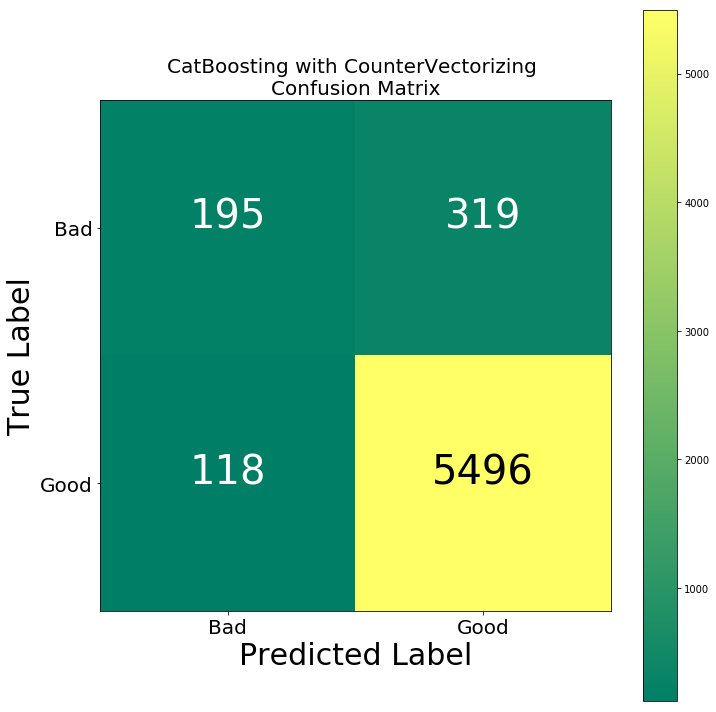

In [31]:
# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

### 4.1.6 Comparison of Models with CountVectorizer

**Functions for Algorithms Comparison**

In [32]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [33]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 Score Plotting**

In [34]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Algorithms Comparison with CountVectorizer**

In [35]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [36]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.915960 bad       0.499334  0.729572  0.592885   
                                  good      0.974149  0.933025  0.953143   
                                  average   0.934323  0.915960  0.922926   
           Random Forest 0.917428 bad       1.000000  0.015564  0.030651   
                                  good      0.917320  1.000000  0.956877   
                                  average   0.924255  0.917428  0.879188   
           Naive Bayes   0.933584 bad       0.691756  0.375486  0.486759   
                                  good      0.945119  0.984681  0.964494   
                                  average   0.923867  0.933584  0.924423   
           XGBoost       0.922487 bad       0.791045  0.103113  0.182444   
                                  good      0.923940  0.997506  0.959315   
                                  average   0.912793  0.922487  0.894153   
           CatBoost      0.928688 bad       0.623003  0.379377  0.471584   
                                  good      0.945142  0.978981  0.961764   
                                  average   0.918122  0.928688  0.920649   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.915960 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917428 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.933584 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.922487 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.928688 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 Score - Models with CountVectorizer**

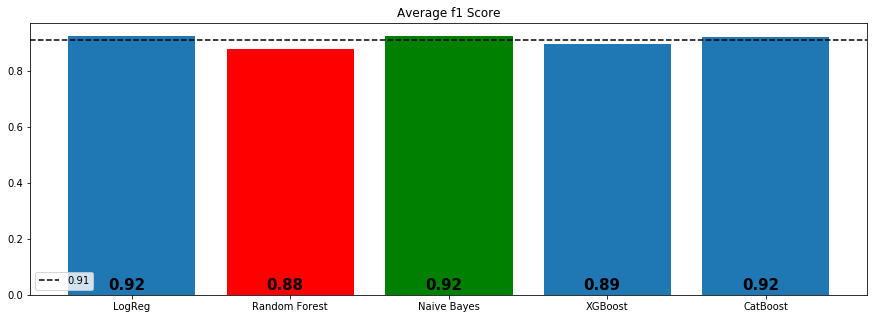

In [37]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

## 4.2 TF-IDF 

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [38]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### 4.2.1 Logistic Regression with TF-IDF

In [39]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8949011705776584


**Classification Report**

In [40]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.39      0.84      0.53       514
           1       0.98      0.88      0.93      5614

   micro avg       0.88      0.88      0.88      6128
   macro avg       0.69      0.86      0.73      6128
weighted avg       0.93      0.88      0.89      6128



**Confusion Matrix**

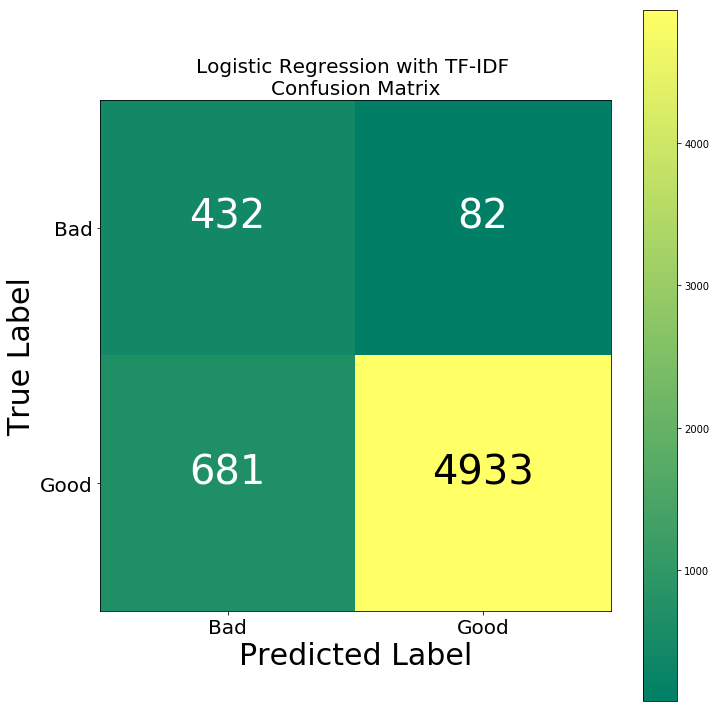

In [41]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [42]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8787963670186205


**Classification Report**

In [62]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

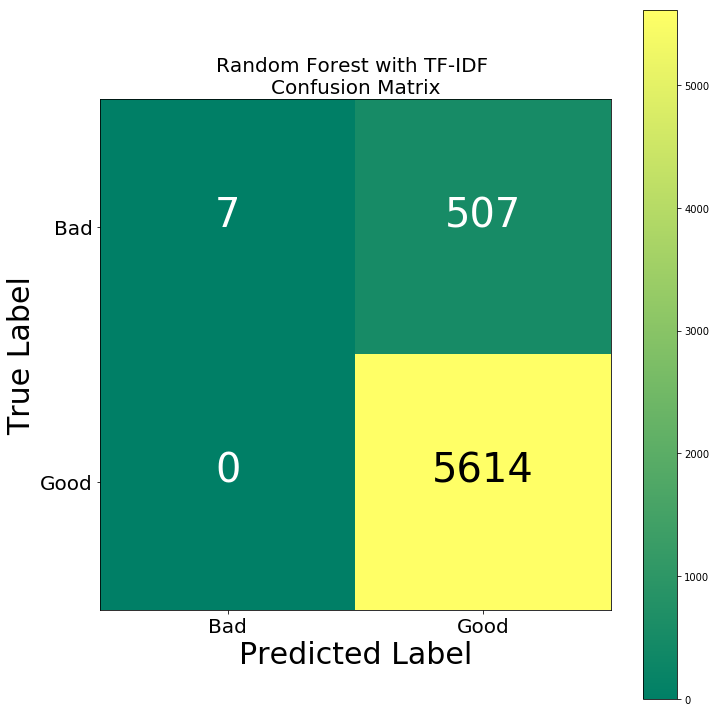

In [63]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [64]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.8760199155649777


**Classification Report**

In [65]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.46      0.50      0.48      6128
weighted avg       0.84      0.92      0.88      6128



**Confusion Matrix**

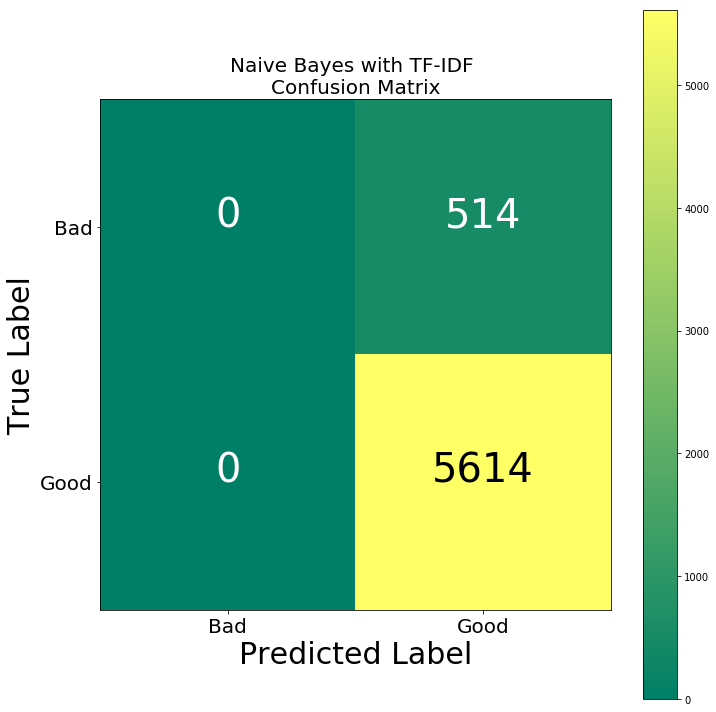

In [66]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [67]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.8971422869530663


**Classification Report**

In [68]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.76      0.12      0.21       514
           1       0.93      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.84      0.56      0.59      6128
weighted avg       0.91      0.92      0.90      6128



**Confusion Matrix**

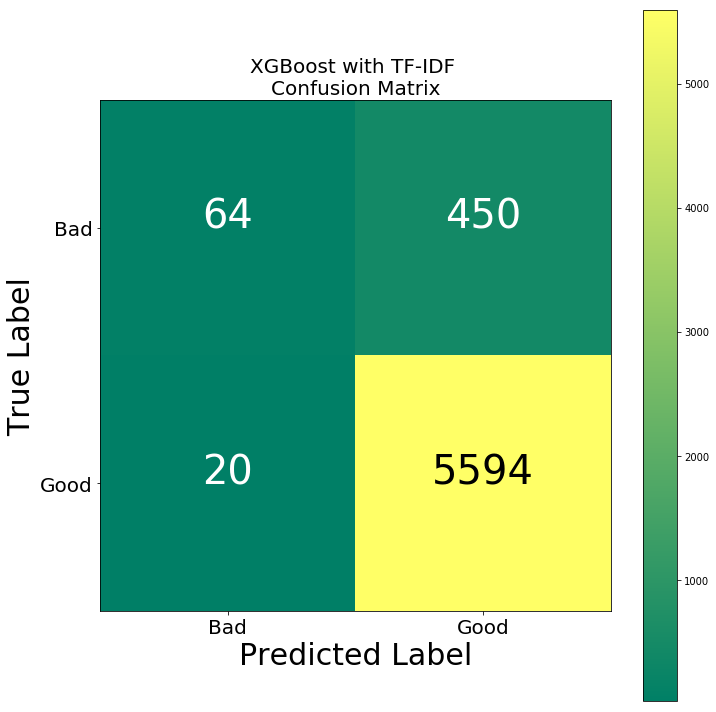

In [69]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.5 Catboost with TF-IDF

In [70]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.3017961	total: 97.5ms	remaining: 2m 26s
1:	learn: 0.2696251	total: 158ms	remaining: 1m 58s
2:	learn: 0.2619843	total: 220ms	remaining: 1m 49s
3:	learn: 0.2565738	total: 285ms	remaining: 1m 46s
4:	learn: 0.2450053	total: 356ms	remaining: 1m 46s
5:	learn: 0.2389871	total: 423ms	remaining: 1m 45s
6:	learn: 0.2377959	total: 484ms	remaining: 1m 43s
7:	learn: 0.2341794	total: 545ms	remaining: 1m 41s
8:	learn: 0.2311943	total: 616ms	remaining: 1m 41s
9:	learn: 0.2272382	total: 681ms	remaining: 1m 41s
10:	learn: 0.2221040	total: 742ms	remaining: 1m 40s
11:	learn: 0.2177505	total: 803ms	remaining: 1m 39s
12:	learn: 0.2163656	total: 872ms	remaining: 1m 39s
13:	learn: 0.2156527	total: 934ms	remaining: 1m 39s
14:	learn: 0.2141913	total: 994ms	remaining: 1m 38s
15:	learn: 0.2119502	total: 1.06s	remaining: 1m 38s
16:	learn: 0.2095777	total: 1.13s	remaining: 1m 38s
17:	learn: 0.2073248	total: 1.19s	remaining: 1m 38s
18:	learn: 0.2063325	total: 1.25s	remaining: 1m 37s
19:	learn: 0.2057055	

159:	learn: 0.1385512	total: 10.1s	remaining: 1m 24s
160:	learn: 0.1384517	total: 10.1s	remaining: 1m 24s
161:	learn: 0.1382750	total: 10.2s	remaining: 1m 24s
162:	learn: 0.1379541	total: 10.2s	remaining: 1m 23s
163:	learn: 0.1376991	total: 10.3s	remaining: 1m 23s
164:	learn: 0.1376643	total: 10.4s	remaining: 1m 23s
165:	learn: 0.1375817	total: 10.4s	remaining: 1m 23s
166:	learn: 0.1373540	total: 10.5s	remaining: 1m 23s
167:	learn: 0.1370764	total: 10.5s	remaining: 1m 23s
168:	learn: 0.1370315	total: 10.6s	remaining: 1m 23s
169:	learn: 0.1369629	total: 10.7s	remaining: 1m 23s
170:	learn: 0.1368313	total: 10.7s	remaining: 1m 23s
171:	learn: 0.1366544	total: 10.8s	remaining: 1m 23s
172:	learn: 0.1364945	total: 10.8s	remaining: 1m 23s
173:	learn: 0.1358098	total: 10.9s	remaining: 1m 23s
174:	learn: 0.1357340	total: 11s	remaining: 1m 22s
175:	learn: 0.1355773	total: 11s	remaining: 1m 22s
176:	learn: 0.1355127	total: 11.1s	remaining: 1m 22s
177:	learn: 0.1354492	total: 11.1s	remaining: 1m 2

315:	learn: 0.1141568	total: 19.5s	remaining: 1m 12s
316:	learn: 0.1141443	total: 19.5s	remaining: 1m 12s
317:	learn: 0.1140323	total: 19.6s	remaining: 1m 12s
318:	learn: 0.1140050	total: 19.6s	remaining: 1m 12s
319:	learn: 0.1139205	total: 19.7s	remaining: 1m 12s
320:	learn: 0.1136543	total: 19.8s	remaining: 1m 12s
321:	learn: 0.1136168	total: 19.8s	remaining: 1m 12s
322:	learn: 0.1135645	total: 19.9s	remaining: 1m 12s
323:	learn: 0.1133292	total: 19.9s	remaining: 1m 12s
324:	learn: 0.1131453	total: 20s	remaining: 1m 12s
325:	learn: 0.1130623	total: 20.1s	remaining: 1m 12s
326:	learn: 0.1130584	total: 20.1s	remaining: 1m 12s
327:	learn: 0.1127594	total: 20.2s	remaining: 1m 12s
328:	learn: 0.1124805	total: 20.2s	remaining: 1m 12s
329:	learn: 0.1122778	total: 20.3s	remaining: 1m 11s
330:	learn: 0.1121587	total: 20.4s	remaining: 1m 11s
331:	learn: 0.1120214	total: 20.4s	remaining: 1m 11s
332:	learn: 0.1119481	total: 20.5s	remaining: 1m 11s
333:	learn: 0.1119255	total: 20.5s	remaining: 1m

475:	learn: 0.1001828	total: 29.1s	remaining: 1m 2s
476:	learn: 0.1001047	total: 29.2s	remaining: 1m 2s
477:	learn: 0.0998230	total: 29.3s	remaining: 1m 2s
478:	learn: 0.0997987	total: 29.3s	remaining: 1m 2s
479:	learn: 0.0997975	total: 29.4s	remaining: 1m 2s
480:	learn: 0.0996476	total: 29.4s	remaining: 1m 2s
481:	learn: 0.0995693	total: 29.5s	remaining: 1m 2s
482:	learn: 0.0995611	total: 29.6s	remaining: 1m 2s
483:	learn: 0.0995437	total: 29.6s	remaining: 1m 2s
484:	learn: 0.0995334	total: 29.7s	remaining: 1m 2s
485:	learn: 0.0995305	total: 29.7s	remaining: 1m 2s
486:	learn: 0.0995246	total: 29.8s	remaining: 1m 1s
487:	learn: 0.0994787	total: 29.9s	remaining: 1m 1s
488:	learn: 0.0994246	total: 29.9s	remaining: 1m 1s
489:	learn: 0.0994150	total: 30s	remaining: 1m 1s
490:	learn: 0.0994128	total: 30.1s	remaining: 1m 1s
491:	learn: 0.0993314	total: 30.1s	remaining: 1m 1s
492:	learn: 0.0992984	total: 30.2s	remaining: 1m 1s
493:	learn: 0.0992973	total: 30.2s	remaining: 1m 1s
494:	learn: 0.

635:	learn: 0.0920671	total: 38.8s	remaining: 52.7s
636:	learn: 0.0920654	total: 38.9s	remaining: 52.6s
637:	learn: 0.0920465	total: 38.9s	remaining: 52.6s
638:	learn: 0.0920430	total: 39s	remaining: 52.5s
639:	learn: 0.0919136	total: 39s	remaining: 52.5s
640:	learn: 0.0918597	total: 39.1s	remaining: 52.4s
641:	learn: 0.0918219	total: 39.2s	remaining: 52.3s
642:	learn: 0.0918079	total: 39.2s	remaining: 52.3s
643:	learn: 0.0917448	total: 39.3s	remaining: 52.2s
644:	learn: 0.0917148	total: 39.3s	remaining: 52.1s
645:	learn: 0.0916352	total: 39.4s	remaining: 52.1s
646:	learn: 0.0916283	total: 39.5s	remaining: 52s
647:	learn: 0.0915240	total: 39.5s	remaining: 52s
648:	learn: 0.0915226	total: 39.6s	remaining: 51.9s
649:	learn: 0.0915189	total: 39.6s	remaining: 51.8s
650:	learn: 0.0915113	total: 39.7s	remaining: 51.8s
651:	learn: 0.0914795	total: 39.8s	remaining: 51.7s
652:	learn: 0.0913161	total: 39.8s	remaining: 51.7s
653:	learn: 0.0912278	total: 39.9s	remaining: 51.6s
654:	learn: 0.091225

795:	learn: 0.0839465	total: 48.5s	remaining: 42.9s
796:	learn: 0.0839424	total: 48.5s	remaining: 42.8s
797:	learn: 0.0839318	total: 48.6s	remaining: 42.8s
798:	learn: 0.0839285	total: 48.7s	remaining: 42.7s
799:	learn: 0.0839195	total: 48.7s	remaining: 42.6s
800:	learn: 0.0838634	total: 48.8s	remaining: 42.6s
801:	learn: 0.0838604	total: 48.8s	remaining: 42.5s
802:	learn: 0.0838070	total: 48.9s	remaining: 42.5s
803:	learn: 0.0837820	total: 49s	remaining: 42.4s
804:	learn: 0.0837188	total: 49s	remaining: 42.3s
805:	learn: 0.0837025	total: 49.1s	remaining: 42.3s
806:	learn: 0.0836669	total: 49.2s	remaining: 42.2s
807:	learn: 0.0836002	total: 49.2s	remaining: 42.2s
808:	learn: 0.0835599	total: 49.3s	remaining: 42.1s
809:	learn: 0.0835232	total: 49.3s	remaining: 42s
810:	learn: 0.0834652	total: 49.4s	remaining: 42s
811:	learn: 0.0834272	total: 49.5s	remaining: 41.9s
812:	learn: 0.0834138	total: 49.5s	remaining: 41.8s
813:	learn: 0.0834082	total: 49.6s	remaining: 41.8s
814:	learn: 0.083392

955:	learn: 0.0799754	total: 58.2s	remaining: 33.1s
956:	learn: 0.0799638	total: 58.2s	remaining: 33s
957:	learn: 0.0799621	total: 58.3s	remaining: 33s
958:	learn: 0.0799348	total: 58.3s	remaining: 32.9s
959:	learn: 0.0799329	total: 58.4s	remaining: 32.8s
960:	learn: 0.0798924	total: 58.5s	remaining: 32.8s
961:	learn: 0.0798238	total: 58.5s	remaining: 32.7s
962:	learn: 0.0798237	total: 58.6s	remaining: 32.7s
963:	learn: 0.0797999	total: 58.6s	remaining: 32.6s
964:	learn: 0.0797954	total: 58.7s	remaining: 32.5s
965:	learn: 0.0797913	total: 58.7s	remaining: 32.5s
966:	learn: 0.0797609	total: 58.8s	remaining: 32.4s
967:	learn: 0.0797577	total: 58.9s	remaining: 32.4s
968:	learn: 0.0797235	total: 58.9s	remaining: 32.3s
969:	learn: 0.0797226	total: 59s	remaining: 32.2s
970:	learn: 0.0796742	total: 59.1s	remaining: 32.2s
971:	learn: 0.0796697	total: 59.1s	remaining: 32.1s
972:	learn: 0.0795820	total: 59.2s	remaining: 32.1s
973:	learn: 0.0795817	total: 59.2s	remaining: 32s
974:	learn: 0.079567

1115:	learn: 0.0752581	total: 1m 7s	remaining: 23.3s
1116:	learn: 0.0752131	total: 1m 7s	remaining: 23.3s
1117:	learn: 0.0751369	total: 1m 7s	remaining: 23.2s
1118:	learn: 0.0751353	total: 1m 7s	remaining: 23.1s
1119:	learn: 0.0751238	total: 1m 8s	remaining: 23.1s
1120:	learn: 0.0750864	total: 1m 8s	remaining: 23s
1121:	learn: 0.0750374	total: 1m 8s	remaining: 23s
1122:	learn: 0.0750234	total: 1m 8s	remaining: 22.9s
1123:	learn: 0.0750151	total: 1m 8s	remaining: 22.8s
1124:	learn: 0.0750131	total: 1m 8s	remaining: 22.8s
1125:	learn: 0.0747979	total: 1m 8s	remaining: 22.7s
1126:	learn: 0.0747368	total: 1m 8s	remaining: 22.6s
1127:	learn: 0.0747035	total: 1m 8s	remaining: 22.6s
1128:	learn: 0.0747025	total: 1m 8s	remaining: 22.5s
1129:	learn: 0.0746793	total: 1m 8s	remaining: 22.5s
1130:	learn: 0.0746636	total: 1m 8s	remaining: 22.4s
1131:	learn: 0.0746453	total: 1m 8s	remaining: 22.3s
1132:	learn: 0.0746189	total: 1m 8s	remaining: 22.3s
1133:	learn: 0.0746066	total: 1m 8s	remaining: 22.

1271:	learn: 0.0701256	total: 1m 17s	remaining: 13.8s
1272:	learn: 0.0701214	total: 1m 17s	remaining: 13.8s
1273:	learn: 0.0701160	total: 1m 17s	remaining: 13.7s
1274:	learn: 0.0701032	total: 1m 17s	remaining: 13.7s
1275:	learn: 0.0701031	total: 1m 17s	remaining: 13.6s
1276:	learn: 0.0699968	total: 1m 17s	remaining: 13.5s
1277:	learn: 0.0699623	total: 1m 17s	remaining: 13.5s
1278:	learn: 0.0699610	total: 1m 17s	remaining: 13.4s
1279:	learn: 0.0699605	total: 1m 17s	remaining: 13.4s
1280:	learn: 0.0699507	total: 1m 17s	remaining: 13.3s
1281:	learn: 0.0699493	total: 1m 17s	remaining: 13.2s
1282:	learn: 0.0699467	total: 1m 17s	remaining: 13.2s
1283:	learn: 0.0699407	total: 1m 17s	remaining: 13.1s
1284:	learn: 0.0699380	total: 1m 17s	remaining: 13s
1285:	learn: 0.0699375	total: 1m 18s	remaining: 13s
1286:	learn: 0.0699316	total: 1m 18s	remaining: 12.9s
1287:	learn: 0.0699287	total: 1m 18s	remaining: 12.9s
1288:	learn: 0.0699241	total: 1m 18s	remaining: 12.8s
1289:	learn: 0.0699233	total: 1m

1427:	learn: 0.0675045	total: 1m 26s	remaining: 4.37s
1428:	learn: 0.0675022	total: 1m 26s	remaining: 4.3s
1429:	learn: 0.0672535	total: 1m 26s	remaining: 4.25s
1430:	learn: 0.0672522	total: 1m 26s	remaining: 4.18s
1431:	learn: 0.0672453	total: 1m 26s	remaining: 4.12s
1432:	learn: 0.0672435	total: 1m 26s	remaining: 4.06s
1433:	learn: 0.0672413	total: 1m 26s	remaining: 4s
1434:	learn: 0.0672352	total: 1m 27s	remaining: 3.94s
1435:	learn: 0.0672339	total: 1m 27s	remaining: 3.88s
1436:	learn: 0.0672271	total: 1m 27s	remaining: 3.82s
1437:	learn: 0.0672243	total: 1m 27s	remaining: 3.76s
1438:	learn: 0.0672230	total: 1m 27s	remaining: 3.7s
1439:	learn: 0.0671850	total: 1m 27s	remaining: 3.64s
1440:	learn: 0.0671718	total: 1m 27s	remaining: 3.58s
1441:	learn: 0.0671659	total: 1m 27s	remaining: 3.52s
1442:	learn: 0.0671270	total: 1m 27s	remaining: 3.46s
1443:	learn: 0.0671141	total: 1m 27s	remaining: 3.4s
1444:	learn: 0.0670497	total: 1m 27s	remaining: 3.33s
1445:	learn: 0.0669720	total: 1m 2

**Classification Report**

In [71]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.56      0.41      0.48       514
           1       0.95      0.97      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.76      0.69      0.72      6128
weighted avg       0.92      0.92      0.92      6128



**Confusion Matrix**

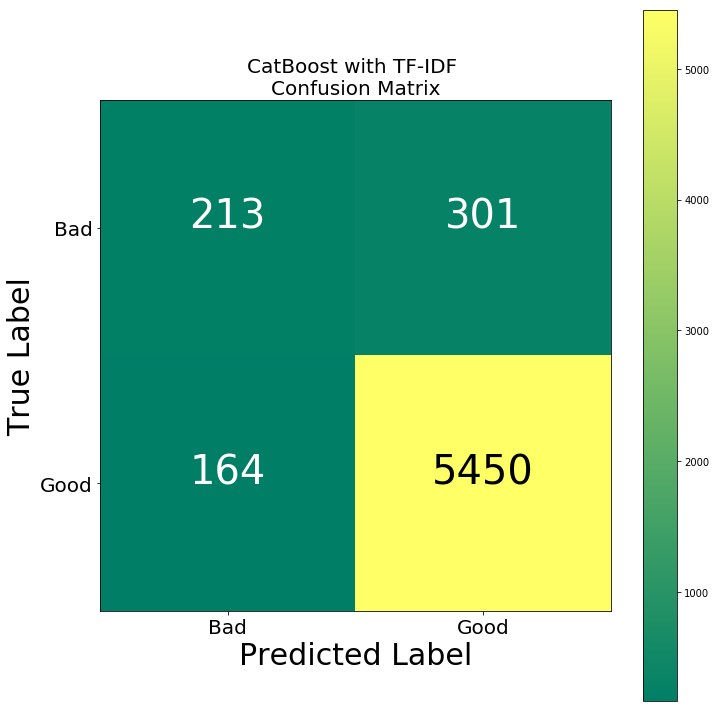

In [72]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoost", "TF-IDF")

### 4.2.6 Comparision of Models with TF-IDF Vectorizer

In [73]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table - TF-IDF Vectorizing**

In [82]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.875490 bad       0.388140  0.840467  0.531039   
                                  good      0.983649  0.878696  0.928215   
                                  average   0.933699  0.875490  0.894901   
           Random Forest 0.917265 bad       1.000000  0.013619  0.026871   
                                  good      0.917170  1.000000  0.956796   
                                  average   0.924118  0.917265  0.878796   
           Naive Bayes   0.916123 bad       0.000000  0.000000  0.000000   
                                  good      0.916123  1.000000  0.956226   
                                  average   0.839281  0.916123  0.876020   
           XGBoost       0.923303 bad       0.761905  0.124514  0.214047   
                                  good      0.925546  0.996437  0.959684   
                                  average   0.911820  0.923303  0.897142   
           CatBoost      0.924119 bad       0.564987  0.414397  0.478114   
                                  good      0.947661  0.970787  0.959085   
                                  average   0.915564  0.924119  0.918742   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.875490 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917265 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.916123 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.923303 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.924119 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - Models with TF-IDF Vectorizer**

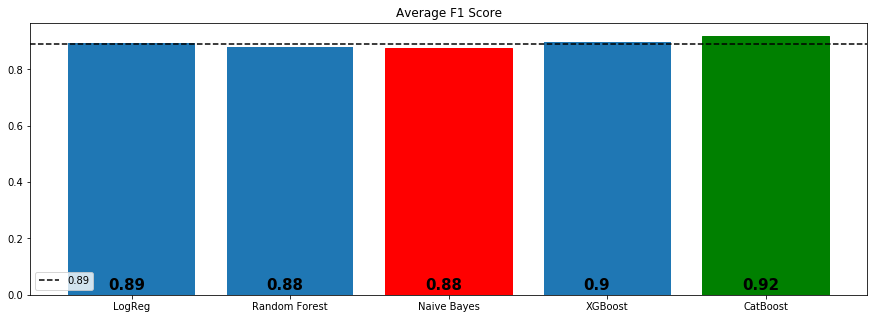

In [81]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4.3 Hashing Vectorizer

Hash Vectorizer is designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies the hashing trick to encode them as numerical indexes. The downside of this method is that once vectorized, the features’ names can no longer be retrieved.

In [76]:
# Create the word vector with Hash Vectorizer
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1,1), non_negative=True)
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

### 4.3.1 Logistic Regression with Hash Vectorizer

In [83]:
# Call the modeling function for logistic regression with Hash Vectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_logreg = y_pred

f1 score: 0.8613702370459698


**Classification Report**

In [84]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_logreg))

              precision    recall  f1-score   support

           0       0.31      0.82      0.45       514
           1       0.98      0.83      0.90      5614

   micro avg       0.83      0.83      0.83      6128
   macro avg       0.64      0.83      0.67      6128
weighted avg       0.92      0.83      0.86      6128



**Confusion Matrix**

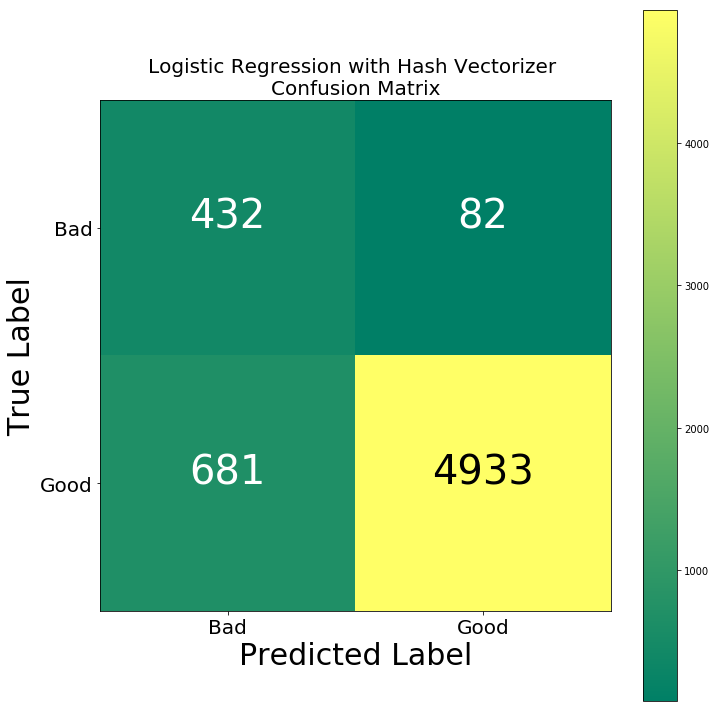

In [85]:
# Print confusion matrix for logistic regression with Hash Vectorizer
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "Hash Vectorizer")

### 4.3.2 Random Forest with Hash Vectorizer

In [86]:
# Call the modeling function for random forest classifier with Hash Vectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_rf = y_pred

f1 score: 0.8787963670186205


**Classification Report**

In [87]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_rf))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

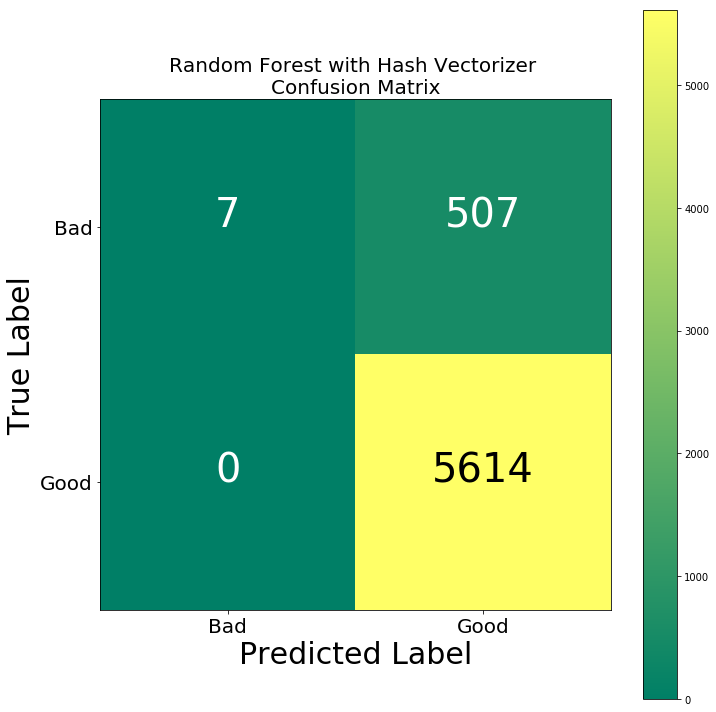

In [88]:
# Print confusion matrix for random forest classifier with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_rf, "Random Forest", "Hash Vectorizer")

### 4.3.3 Naive Bayes with Hash Vectorizer

In [89]:
# Call the modeling function for naive bayes with Hash Vectorizer and print f1 score
modeling(MultinomialNB(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_nb = y_pred

f1 score: 0.8761740049132273


**Classification Report**

In [90]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_nb))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.58      0.50      0.48      6128
weighted avg       0.86      0.92      0.88      6128



**Confusion Matrix**

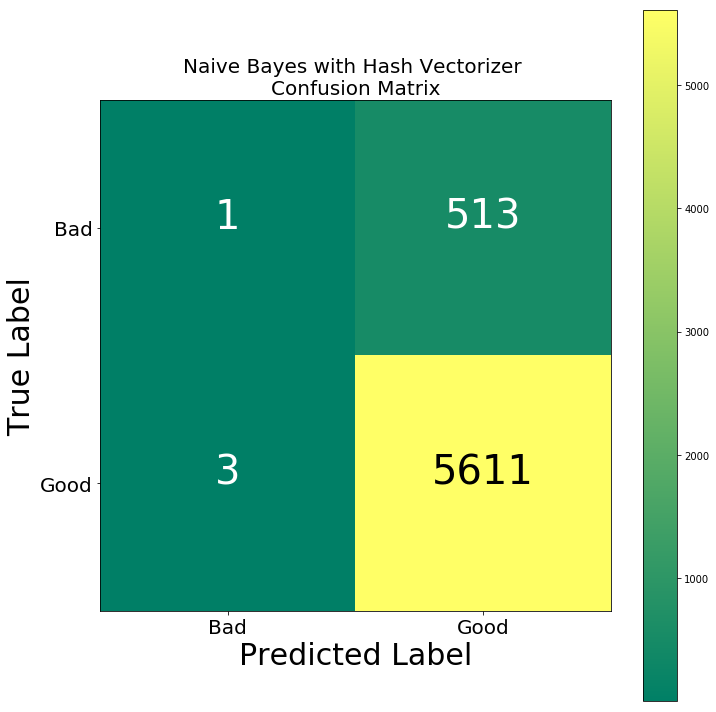

In [91]:
# Print confusion matrix for naive bayes with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_nb, "Naive Bayes", "Hash Vectorizer")

### 4.3.4 XGBoost with Hash Vectorizer

In [92]:
# Call the modeling function for XGBoost with Hash Vectorizer and print f1 score
modeling(XGBClassifier(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_xgb = y_pred

f1 score: 0.8942279470073832


**Classification Report**

In [93]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_xgb))

              precision    recall  f1-score   support

           0       0.88      0.10      0.18       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.90      0.55      0.57      6128
weighted avg       0.92      0.92      0.89      6128



**Confusion Matrix**

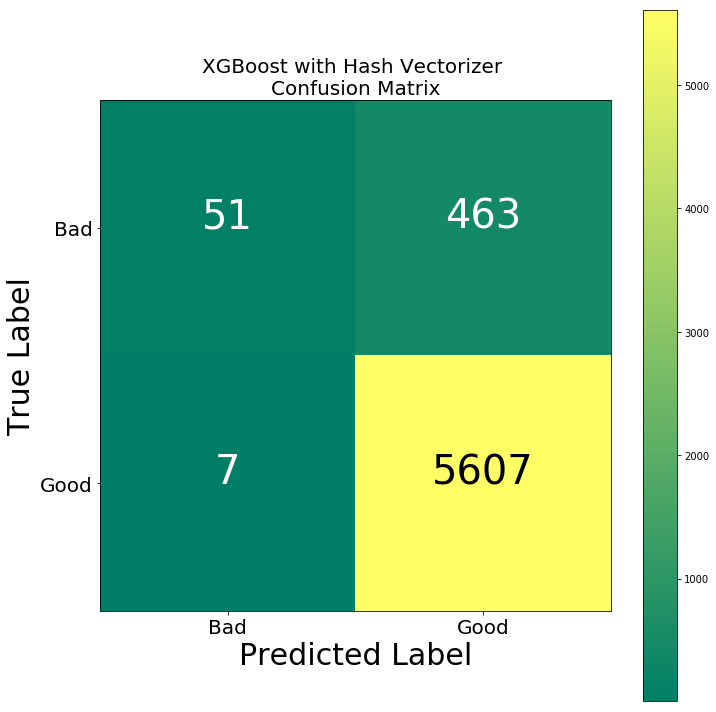

In [94]:
# Print confusion matrix for XGBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_xgb, "XGBoost", "Hash Vectorizer")

### 4.3.5 CatBoost with Hash Vectorizer

In [95]:
# Call the modeling function for Catboost with Hash Vectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_catboost = y_pred

0:	learn: 0.3017835	total: 75.7ms	remaining: 1m 53s
1:	learn: 0.2735269	total: 119ms	remaining: 1m 28s
2:	learn: 0.2603304	total: 164ms	remaining: 1m 21s
3:	learn: 0.2558243	total: 206ms	remaining: 1m 17s
4:	learn: 0.2469332	total: 248ms	remaining: 1m 14s
5:	learn: 0.2431727	total: 298ms	remaining: 1m 14s
6:	learn: 0.2408913	total: 343ms	remaining: 1m 13s
7:	learn: 0.2378472	total: 388ms	remaining: 1m 12s
8:	learn: 0.2318382	total: 430ms	remaining: 1m 11s
9:	learn: 0.2285482	total: 473ms	remaining: 1m 10s
10:	learn: 0.2260317	total: 522ms	remaining: 1m 10s
11:	learn: 0.2252216	total: 567ms	remaining: 1m 10s
12:	learn: 0.2232516	total: 612ms	remaining: 1m 9s
13:	learn: 0.2222334	total: 655ms	remaining: 1m 9s
14:	learn: 0.2198365	total: 698ms	remaining: 1m 9s
15:	learn: 0.2189452	total: 744ms	remaining: 1m 8s
16:	learn: 0.2176879	total: 790ms	remaining: 1m 8s
17:	learn: 0.2151565	total: 837ms	remaining: 1m 8s
18:	learn: 0.2139209	total: 881ms	remaining: 1m 8s
19:	learn: 0.2096570	total: 

165:	learn: 0.1464648	total: 7.42s	remaining: 59.6s
166:	learn: 0.1464233	total: 7.46s	remaining: 59.6s
167:	learn: 0.1460652	total: 7.51s	remaining: 59.5s
168:	learn: 0.1458444	total: 7.55s	remaining: 59.5s
169:	learn: 0.1457112	total: 7.59s	remaining: 59.4s
170:	learn: 0.1456264	total: 7.64s	remaining: 59.4s
171:	learn: 0.1454399	total: 7.68s	remaining: 59.3s
172:	learn: 0.1454034	total: 7.73s	remaining: 59.3s
173:	learn: 0.1451788	total: 7.77s	remaining: 59.2s
174:	learn: 0.1451201	total: 7.81s	remaining: 59.2s
175:	learn: 0.1449691	total: 7.86s	remaining: 59.1s
176:	learn: 0.1448951	total: 7.9s	remaining: 59.1s
177:	learn: 0.1446286	total: 7.95s	remaining: 59s
178:	learn: 0.1442514	total: 7.99s	remaining: 59s
179:	learn: 0.1439394	total: 8.03s	remaining: 58.9s
180:	learn: 0.1439065	total: 8.08s	remaining: 58.9s
181:	learn: 0.1437799	total: 8.12s	remaining: 58.8s
182:	learn: 0.1437221	total: 8.17s	remaining: 58.8s
183:	learn: 0.1437046	total: 8.21s	remaining: 58.7s
184:	learn: 0.143

325:	learn: 0.1293423	total: 14.5s	remaining: 52.1s
326:	learn: 0.1293422	total: 14.5s	remaining: 52s
327:	learn: 0.1293128	total: 14.5s	remaining: 52s
328:	learn: 0.1292883	total: 14.6s	remaining: 51.9s
329:	learn: 0.1292679	total: 14.6s	remaining: 51.9s
330:	learn: 0.1287738	total: 14.7s	remaining: 51.9s
331:	learn: 0.1287130	total: 14.7s	remaining: 51.8s
332:	learn: 0.1287064	total: 14.8s	remaining: 51.8s
333:	learn: 0.1285086	total: 14.8s	remaining: 51.7s
334:	learn: 0.1284614	total: 14.9s	remaining: 51.7s
335:	learn: 0.1284604	total: 14.9s	remaining: 51.7s
336:	learn: 0.1284424	total: 15s	remaining: 51.6s
337:	learn: 0.1283121	total: 15s	remaining: 51.6s
338:	learn: 0.1281698	total: 15s	remaining: 51.5s
339:	learn: 0.1280365	total: 15.1s	remaining: 51.5s
340:	learn: 0.1278995	total: 15.1s	remaining: 51.5s
341:	learn: 0.1278522	total: 15.2s	remaining: 51.4s
342:	learn: 0.1277538	total: 15.2s	remaining: 51.4s
343:	learn: 0.1277513	total: 15.3s	remaining: 51.3s
344:	learn: 0.1277071	

484:	learn: 0.1141998	total: 21.6s	remaining: 45.2s
485:	learn: 0.1141653	total: 21.7s	remaining: 45.2s
486:	learn: 0.1141430	total: 21.7s	remaining: 45.1s
487:	learn: 0.1141302	total: 21.7s	remaining: 45.1s
488:	learn: 0.1141103	total: 21.8s	remaining: 45s
489:	learn: 0.1140532	total: 21.8s	remaining: 45s
490:	learn: 0.1139221	total: 21.9s	remaining: 45s
491:	learn: 0.1135537	total: 21.9s	remaining: 44.9s
492:	learn: 0.1135488	total: 22s	remaining: 44.9s
493:	learn: 0.1135418	total: 22s	remaining: 44.8s
494:	learn: 0.1135012	total: 22.1s	remaining: 44.8s
495:	learn: 0.1134089	total: 22.1s	remaining: 44.8s
496:	learn: 0.1133712	total: 22.2s	remaining: 44.7s
497:	learn: 0.1133657	total: 22.2s	remaining: 44.7s
498:	learn: 0.1133075	total: 22.2s	remaining: 44.6s
499:	learn: 0.1133013	total: 22.3s	remaining: 44.6s
500:	learn: 0.1132850	total: 22.3s	remaining: 44.5s
501:	learn: 0.1132819	total: 22.4s	remaining: 44.5s
502:	learn: 0.1132815	total: 22.4s	remaining: 44.4s
503:	learn: 0.1131311	

644:	learn: 0.1074738	total: 28.7s	remaining: 38.1s
645:	learn: 0.1074209	total: 28.8s	remaining: 38.1s
646:	learn: 0.1073334	total: 28.8s	remaining: 38s
647:	learn: 0.1072970	total: 28.9s	remaining: 38s
648:	learn: 0.1072962	total: 28.9s	remaining: 37.9s
649:	learn: 0.1072936	total: 29s	remaining: 37.9s
650:	learn: 0.1072935	total: 29s	remaining: 37.8s
651:	learn: 0.1072073	total: 29.1s	remaining: 37.8s
652:	learn: 0.1072053	total: 29.1s	remaining: 37.7s
653:	learn: 0.1072007	total: 29.1s	remaining: 37.7s
654:	learn: 0.1071658	total: 29.2s	remaining: 37.7s
655:	learn: 0.1066182	total: 29.2s	remaining: 37.6s
656:	learn: 0.1066165	total: 29.3s	remaining: 37.6s
657:	learn: 0.1065626	total: 29.3s	remaining: 37.5s
658:	learn: 0.1065625	total: 29.4s	remaining: 37.5s
659:	learn: 0.1065141	total: 29.4s	remaining: 37.4s
660:	learn: 0.1064905	total: 29.5s	remaining: 37.4s
661:	learn: 0.1063789	total: 29.5s	remaining: 37.3s
662:	learn: 0.1063708	total: 29.5s	remaining: 37.3s
663:	learn: 0.106363

804:	learn: 0.1002507	total: 35.9s	remaining: 31s
805:	learn: 0.1002401	total: 35.9s	remaining: 30.9s
806:	learn: 0.1002399	total: 36s	remaining: 30.9s
807:	learn: 0.1002286	total: 36s	remaining: 30.8s
808:	learn: 0.1002278	total: 36.1s	remaining: 30.8s
809:	learn: 0.1002277	total: 36.1s	remaining: 30.8s
810:	learn: 0.1002133	total: 36.2s	remaining: 30.7s
811:	learn: 0.1002133	total: 36.2s	remaining: 30.7s
812:	learn: 0.1000031	total: 36.2s	remaining: 30.6s
813:	learn: 0.0999007	total: 36.3s	remaining: 30.6s
814:	learn: 0.0998984	total: 36.3s	remaining: 30.5s
815:	learn: 0.0998931	total: 36.4s	remaining: 30.5s
816:	learn: 0.0998592	total: 36.4s	remaining: 30.4s
817:	learn: 0.0998585	total: 36.5s	remaining: 30.4s
818:	learn: 0.0998575	total: 36.5s	remaining: 30.4s
819:	learn: 0.0998556	total: 36.6s	remaining: 30.3s
820:	learn: 0.0997614	total: 36.6s	remaining: 30.3s
821:	learn: 0.0997600	total: 36.6s	remaining: 30.2s
822:	learn: 0.0997243	total: 36.7s	remaining: 30.2s
823:	learn: 0.0996

964:	learn: 0.0953597	total: 43s	remaining: 23.9s
965:	learn: 0.0953587	total: 43.1s	remaining: 23.8s
966:	learn: 0.0953209	total: 43.1s	remaining: 23.8s
967:	learn: 0.0952894	total: 43.2s	remaining: 23.7s
968:	learn: 0.0952764	total: 43.2s	remaining: 23.7s
969:	learn: 0.0952319	total: 43.3s	remaining: 23.6s
970:	learn: 0.0951767	total: 43.3s	remaining: 23.6s
971:	learn: 0.0951723	total: 43.4s	remaining: 23.5s
972:	learn: 0.0951710	total: 43.4s	remaining: 23.5s
973:	learn: 0.0951670	total: 43.4s	remaining: 23.5s
974:	learn: 0.0951623	total: 43.5s	remaining: 23.4s
975:	learn: 0.0951612	total: 43.5s	remaining: 23.4s
976:	learn: 0.0951572	total: 43.6s	remaining: 23.3s
977:	learn: 0.0951500	total: 43.6s	remaining: 23.3s
978:	learn: 0.0949552	total: 43.7s	remaining: 23.2s
979:	learn: 0.0949547	total: 43.7s	remaining: 23.2s
980:	learn: 0.0949189	total: 43.8s	remaining: 23.1s
981:	learn: 0.0948312	total: 43.8s	remaining: 23.1s
982:	learn: 0.0945301	total: 43.8s	remaining: 23.1s
983:	learn: 0.

1124:	learn: 0.0893330	total: 50.2s	remaining: 16.7s
1125:	learn: 0.0892841	total: 50.3s	remaining: 16.7s
1126:	learn: 0.0892499	total: 50.3s	remaining: 16.6s
1127:	learn: 0.0892493	total: 50.3s	remaining: 16.6s
1128:	learn: 0.0892488	total: 50.4s	remaining: 16.6s
1129:	learn: 0.0892458	total: 50.4s	remaining: 16.5s
1130:	learn: 0.0892434	total: 50.5s	remaining: 16.5s
1131:	learn: 0.0892403	total: 50.5s	remaining: 16.4s
1132:	learn: 0.0892382	total: 50.6s	remaining: 16.4s
1133:	learn: 0.0892366	total: 50.6s	remaining: 16.3s
1134:	learn: 0.0892259	total: 50.7s	remaining: 16.3s
1135:	learn: 0.0892078	total: 50.7s	remaining: 16.2s
1136:	learn: 0.0892033	total: 50.8s	remaining: 16.2s
1137:	learn: 0.0891993	total: 50.8s	remaining: 16.2s
1138:	learn: 0.0891869	total: 50.8s	remaining: 16.1s
1139:	learn: 0.0891840	total: 50.9s	remaining: 16.1s
1140:	learn: 0.0891840	total: 50.9s	remaining: 16s
1141:	learn: 0.0891786	total: 51s	remaining: 16s
1142:	learn: 0.0891772	total: 51s	remaining: 15.9s
1

1282:	learn: 0.0846178	total: 57.4s	remaining: 9.72s
1283:	learn: 0.0844660	total: 57.5s	remaining: 9.67s
1284:	learn: 0.0844658	total: 57.5s	remaining: 9.63s
1285:	learn: 0.0844649	total: 57.6s	remaining: 9.58s
1286:	learn: 0.0844578	total: 57.6s	remaining: 9.54s
1287:	learn: 0.0841621	total: 57.7s	remaining: 9.49s
1288:	learn: 0.0841505	total: 57.7s	remaining: 9.45s
1289:	learn: 0.0841251	total: 57.8s	remaining: 9.4s
1290:	learn: 0.0841045	total: 57.8s	remaining: 9.36s
1291:	learn: 0.0841039	total: 57.9s	remaining: 9.31s
1292:	learn: 0.0841028	total: 57.9s	remaining: 9.27s
1293:	learn: 0.0841027	total: 57.9s	remaining: 9.22s
1294:	learn: 0.0841027	total: 58s	remaining: 9.18s
1295:	learn: 0.0841014	total: 58s	remaining: 9.13s
1296:	learn: 0.0841005	total: 58.1s	remaining: 9.09s
1297:	learn: 0.0840986	total: 58.1s	remaining: 9.04s
1298:	learn: 0.0839779	total: 58.2s	remaining: 9s
1299:	learn: 0.0839084	total: 58.2s	remaining: 8.96s
1300:	learn: 0.0839070	total: 58.3s	remaining: 8.91s
1

1442:	learn: 0.0789139	total: 1m 4s	remaining: 2.55s
1443:	learn: 0.0788362	total: 1m 4s	remaining: 2.51s
1444:	learn: 0.0786708	total: 1m 4s	remaining: 2.46s
1445:	learn: 0.0786707	total: 1m 4s	remaining: 2.42s
1446:	learn: 0.0786669	total: 1m 4s	remaining: 2.37s
1447:	learn: 0.0786669	total: 1m 4s	remaining: 2.33s
1448:	learn: 0.0786662	total: 1m 4s	remaining: 2.29s
1449:	learn: 0.0786653	total: 1m 4s	remaining: 2.24s
1450:	learn: 0.0786548	total: 1m 5s	remaining: 2.19s
1451:	learn: 0.0785691	total: 1m 5s	remaining: 2.15s
1452:	learn: 0.0785669	total: 1m 5s	remaining: 2.11s
1453:	learn: 0.0785665	total: 1m 5s	remaining: 2.06s
1454:	learn: 0.0785549	total: 1m 5s	remaining: 2.02s
1455:	learn: 0.0785498	total: 1m 5s	remaining: 1.97s
1456:	learn: 0.0785446	total: 1m 5s	remaining: 1.93s
1457:	learn: 0.0785432	total: 1m 5s	remaining: 1.88s
1458:	learn: 0.0785423	total: 1m 5s	remaining: 1.84s
1459:	learn: 0.0785422	total: 1m 5s	remaining: 1.79s
1460:	learn: 0.0785416	total: 1m 5s	remaining:

**Classification Report**

In [96]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_catboost))

              precision    recall  f1-score   support

           0       0.59      0.40      0.48       514
           1       0.95      0.97      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.77      0.69      0.72      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

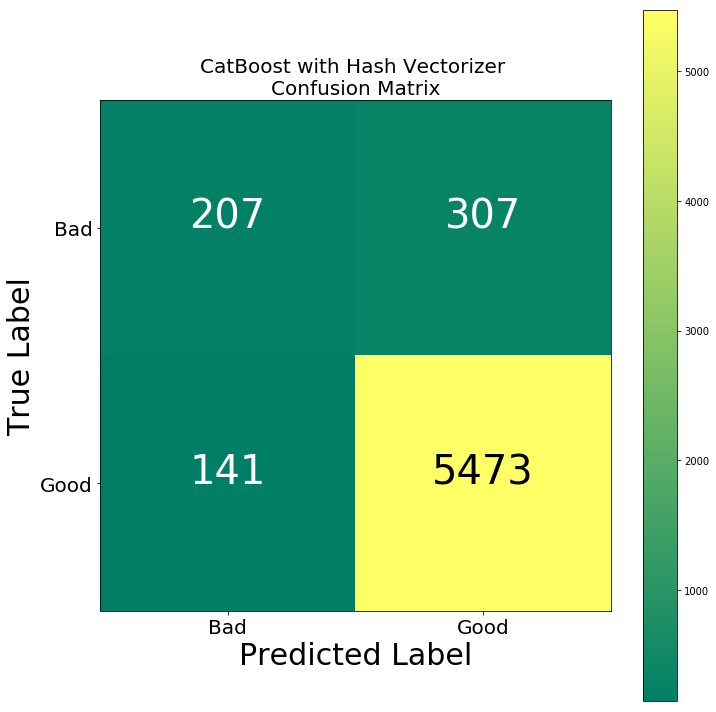

In [97]:
# Print confusion matrix for CatBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_catboost, "CatBoost", "Hash Vectorizer")

### 4.3.6 Comparison of Models with Hash Vectorizer

In [98]:
comparison_table(y_preds = [y_pred_hash_logreg, y_pred_hash_rf, y_pred_hash_nb, y_pred_hash_xgb, y_pred_hash_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table**

In [99]:
# Print the comparision matrix
print('\nComparision Matrix of Models with Hash Vectorizer\n')
df_tv2


Comparision Matrix of Models with Hash Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.829634 bad       0.307132  0.821012  0.447034   
                                  good      0.980648  0.830424  0.899306   
                                  average   0.924155  0.829634  0.861370   
           Random Forest 0.917265 bad       1.000000  0.013619  0.026871   
                                  good      0.917170  1.000000  0.956796   
                                  average   0.924118  0.917265  0.878796   
           Naive Bayes   0.915796 bad       0.250000  0.001946  0.003861   
                                  good      0.916231  0.999466  0.956040   
                                  average   0.860350  0.915796  0.876174   
           XGBoost       0.923303 bad       0.879310  0.099222  0.178322   
                                  good      0.923723  0.998753  0.959774   
                                  average   0.919998  0.923303  0.894228   
           CatBoost      0.926893 bad       0.594828  0.402724  0.480278   
                                  good      0.946886  0.974884  0.960681   
                                  average   0.917356  0.926893  0.920386   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.829634 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917265 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.915796 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.923303 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.926893 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - Hash Vectorizer**

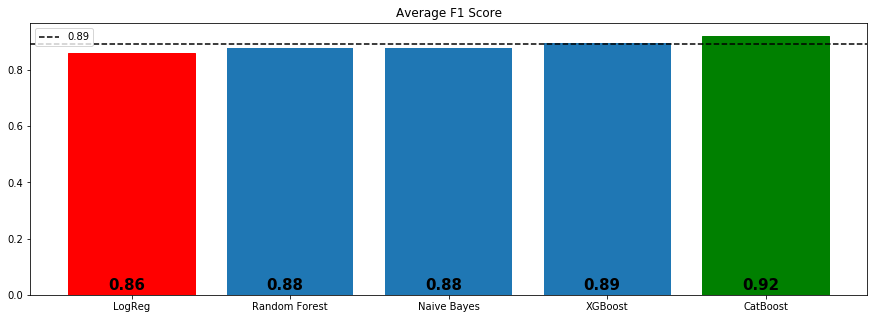

In [100]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")